# Solar System Simulation with Runge-Kutta and GPU Acceleration

This project simulates the motion of bodies in the solar system using numerical integration methods. In particular, it implements the **Runge-Kutta 4th order (RK4)** solver to integrate the equations of motion governed by Newton's law of gravitation.

To explore computational performance, the simulation is executed using both **CPU-based NumPy** and **GPU-accelerated CuPy**. The goal is to compare runtime efficiency and scalability, making this project a useful demonstration of scientific computing with Python and GPU acceleration.

The notebook includes:
- Physics and constants setup
- RK4 integrator implementation
- CPU and GPU simulations
- Visualization of planetary orbits
- Performance benchmarking


## Imports and Constants

We begin by importing necessary libraries and defining physical constants like the gravitational constant and astronomical unit. We also specify the masses and identifiers of the solar system bodies.


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import cupy as cp
from astroquery.jplhorizons import Horizons
from astropy.time import Time
import pickle

# Constants
AU = 1.496e+11 # Astronomical unit in meters
day_s = 24*60*60 # Seconds in a day
G = 6.67430e-11 # Gravitaional constant in m^3 kg^-1 s^-2

planet_masses = {
	'Sun': 1.989e+30,  
	'Mercury': 3.285e+23,
	'Venus': 4.869e+24,
	'Earth': 5.976e+24,
	'Mars': 6.421e+23,
	'Jupiter': 1.899e+27,
	'Saturn': 5.685e+26,
	'Uranus': 8.681e+25,
	'Neptune': 1.024e+26
}

planet_ids = [10, 199, 299, 399, 499, 599, 699, 799, 899]

## Defining the Celestial Body Class

Each body (planet or star) in the simulation is represented by an instance of the `Body` class, which holds its name, position, velocity, and mass.


In [31]:
# Class to represent a celestial body
class Body(object):
    def __init__(self, name, init_p, init_v, mass):
        self.name = name
        self.state = [*init_p, *init_v] # [x, y, z, vx, vy, vz]
        self.p = init_p
        self.v = init_v
        self.m = mass

## CPU Simulation with RK4

This function simulates the motion of the bodies using a Runge-Kutta 4th order integration on the **CPU**. It calculates the gravitational acceleration between all pairs of bodies and updates their positions and velocities at each time step.

In [58]:
# Main function to run the simulation on CPU
def run_sim_cpu(bodies, t, dt):
    mass = np.array([[b.m] for b in bodies], dtype=float) # (n)
    vel = np.array([b.v for b in bodies], dtype=float) # (n, 3)
    pos = np.array([b.p for b in bodies], dtype=float) # (n, 3)
    names = np.array([b.name for b in bodies], dtype=str)
    mass_broadcast = mass[None, :, :]  # shape (1, N, 1)
    
    def get_acceleration(pos):
        # Return dy/dt = [vx, vx, vz, ax, ay, az]
        dr = pos[None, :, :] - pos[:, None, :]  # shape (N, N, 3)
        distance = np.linalg.norm(dr, axis=2)
        mask = np.eye(pos.shape[0], dtype=bool)
        distance[mask] = np.inf  # Avoid self-force
        r3 = distance[..., None] ** 3
        acc = G * np.sum(dr / r3 * mass_broadcast, axis=1)
        return acc

    def RK4_step(pos, vel, dt):
        v1 = vel
        a1 = get_acceleration(pos)
        v2 = vel + a1*0.5*dt
        a2 = get_acceleration(pos+v1*0.5*dt) 
        v3 = vel + a2*0.5*dt
        a3 = get_acceleration(pos+v2*0.5*dt)
        v4 = vel + a3*dt
        a4 = get_acceleration(pos+v3*dt) 
        return pos + (v1 + 2*v2 + 2*v3 + v4) / 6*dt, vel + (a1 + 2*a2 + 2*a3 + a4) / 6*dt
    
    # save positions and velocities for plotting
    plt_pos = np.empty((floor(t/dt), pos.shape[0], pos.shape[1]))
    plt_vel = np.empty((floor(t/dt), pos.shape[0], pos.shape[1]))

    N = floor(t/dt)

    for i in range(0,N):
        pos, vel = RK4_step(pos, vel, dt)
        plt_pos[i] = pos

    return plt_pos, N

## GPU-Accelerated Simulation with CuPy

This function mirrors the CPU implementation but uses CuPy arrays to perform computations on the **GPU**. This significantly accelerates the calculation of pairwise gravitational forces, especially for large N-body systems.


In [ ]:
def run_sim_gpu(bodies, t, dt):
    names = np.array([b.name for b in bodies], dtype=str)

    # Move to GPU
    mass_gpu = cp.array([[b.m] for b in bodies], dtype=float)  # (n, 1)
    vel_gpu = cp.array([b.v for b in bodies], dtype=float)  # (n, 3)
    pos_gpu = cp.array([b.p for b in bodies], dtype=float)  # (n, 3)
    mass_broadcast = mass_gpu[None, :, :]  # shape (1, N, 1)

    def get_acceleration(pos):
        # Return dy/dt = [vx, vx, vz, ax, ay, az]
        dr = pos[None, :, :] - pos[:, None, :]  # shape (N, N, 3)
        distance = cp.linalg.norm(dr, axis=2)
        mask = cp.eye(pos.shape[0], dtype=bool)
        distance[mask] = cp.inf  # Avoid self-force
        r3 = distance[..., None] ** 3
        acc = G * cp.sum(dr / r3 * mass_broadcast, axis=1)
        return acc

    def RK4_step(pos, vel, dt):
        v1 = vel
        a1 = get_acceleration(pos)
        v2 = vel + a1 * 0.5 * dt
        a2 = get_acceleration(pos + v1 * 0.5 * dt)
        v3 = vel + a2 * 0.5 * dt
        a3 = get_acceleration(pos + v2 * 0.5 * dt)
        v4 = vel + a3 * dt
        a4 = get_acceleration(pos + v3 * dt)
        return pos + (v1 + 2*v2 + 2*v3 + v4) / 6*dt, vel + (a1 + 2*a2 + 2*a3 + a4) / 6*dt

    N = floor(t / dt)
    plt_pos = cp.empty((N, pos_gpu.shape[0], pos_gpu.shape[1]))

    for i in range(N):
        pos_gpu, vel_gpu = RK4_step(pos_gpu, vel_gpu, dt)
        plt_pos[i] = pos_gpu

    # Move back to CPU for plotting
    plt_pos= cp.asnumpy(plt_pos)

    return plt_pos, N

## Downloading Planetary Data from JPL Horizons

To initialize the simulation with realistic positions and velocities, this section uses the `astroquery` package to fetch vector data from NASA's JPL Horizons system. We start with all the major planets, including mercury

In [63]:
epoch = Time('2012-01-25')

bodies = []
for x, y in planet_masses.items():
    id = planet_ids[list(planet_masses.keys()).index(x)]
    body_data = Horizons(id=id, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding {x} with id {id}")
    bodies.append(Body(x, 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      y))


Adding Sun with id 10
Adding Mercury with id 199
Adding Venus with id 299
Adding Earth with id 399
Adding Mars with id 499
Adding Jupiter with id 599
Adding Saturn with id 699
Adding Uranus with id 799
Adding Neptune with id 899


## Running the Simulation

The following section runs the simulation using the initialized planetary data. It uses the RK4 solver for both CPU and GPU backends and stores the trajectory data.


In [64]:
%%time

plt_pos, N = run_sim_cpu(
    bodies=bodies,
    t=10 * 365 * day_s,
    dt=10 * day_s,
)

CPU times: total: 62.5 ms
Wall time: 50.7 ms


In [65]:
%%time

# Run the simulation on GPU
plt_pos, N = run_sim_gpu(
    bodies=bodies,
    t=10 * 365 * day_s,
    dt=10 * day_s,
)

CPU times: total: 1.47 s
Wall time: 1.47 s


## Performance Benchmarking

We can see that the CPU version actually runs faster in this case, this is because the advantage of the GPU is it can do individual body calculations in parallel, so with only 9 bodies the GPU compute time is dominated by memory transfers to and from the GPU, meaning the pure CPU version is actually faster for low body count. Later on we'll show how the difference in compute time scales with the number of bodies.

## Visualizing Planetary Orbits

After simulation, we visualize the planetary orbits to verify the physical correctness and stability of the integration method.


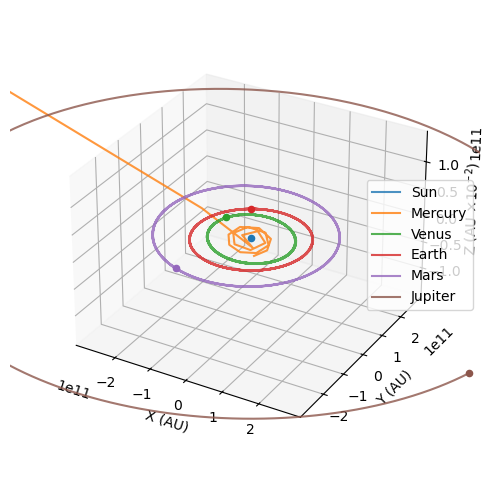

In [66]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')
for i in range(0, 6):
    ax.plot(plt_pos[:, i, 0], plt_pos[:, i, 1], plt_pos[:, i, 2], alpha=0.8, label=bodies[i].name)
    ax.scatter(plt_pos[-1, i, 0], plt_pos[-1, i, 1], plt_pos[-1, i, 2], marker="o")

ax.set_box_aspect(None, zoom=0.85)
limits = [2, 2, 100]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X (AU)")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y (AU)")
ax.set(
    zlim3d=(-limits[2] * AU * 1e-2, limits[2] * AU * 1e-2),
    zlabel="Z (AU $\\times10^{-2}$)",
)
ax.legend()
fig.tight_layout()

Mercury seems to get ejected so let's try a smaller time step `dt`

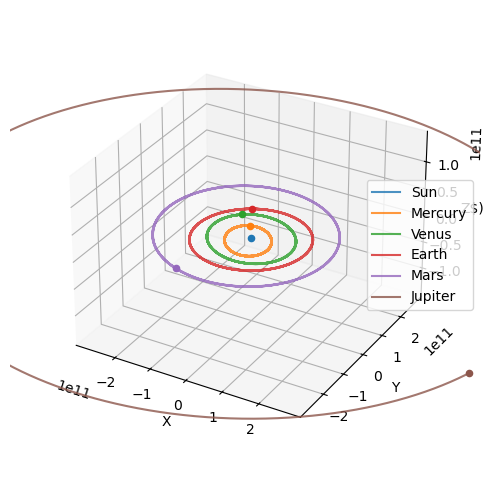

In [67]:
plt_pos, N = run_sim_cpu(
	bodies=bodies,
	t = 10 * 365 * day_s,
	dt = 0.1 * day_s
)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')
for i in range(0, 6):
    ax.plot(plt_pos[:, i, 0], plt_pos[:, i, 1], plt_pos[:, i, 2], alpha=0.8, label=bodies[i].name)
    ax.scatter(plt_pos[-1, i, 0], plt_pos[-1, i, 1], plt_pos[-1, i, 2], marker="o")

ax.set_box_aspect(None, zoom=0.85)
limits = [2, 2, 100]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax.set(
    zlim3d=(-limits[2] * AU * 1e-2, limits[2] * AU * 1e-2),
    zlabel="Z$)",
)
ax.legend()
fig.tight_layout()

We now have stable orbits for all 9 major planets, let's plot further zoomed out to see the rest of the planets

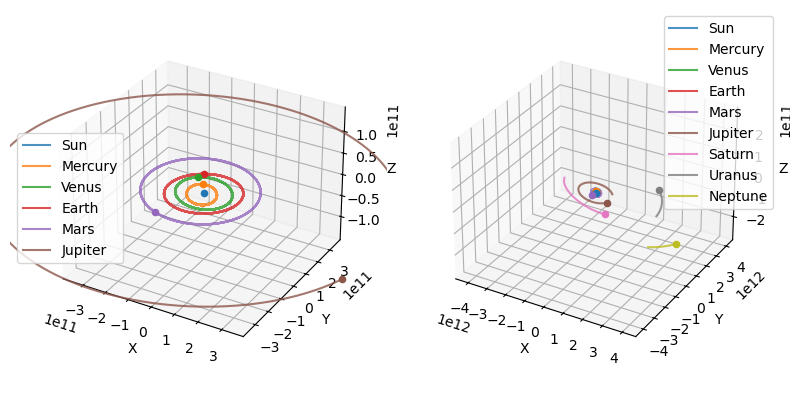

In [68]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for i in range(0, 6):
    ax.plot(plt_pos[:, i, 0], plt_pos[:, i, 1], plt_pos[:, i, 2], alpha=0.8, label=bodies[i].name)
    ax.scatter(plt_pos[-1, i, 0], plt_pos[-1, i, 1], plt_pos[-1, i, 2], marker="o")

for i in range(0, 9):
    ax2.plot(plt_pos[:, i, 0], plt_pos[:, i, 1], plt_pos[:, i, 2], alpha=0.8, label=bodies[i].name)
    ax2.scatter(plt_pos[-1, i, 0], plt_pos[-1, i, 1], plt_pos[-1, i, 2], marker="o")

ax.set_box_aspect(None, zoom=0.85)
limits = [2.5, 2.5, 100]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax.set(
    zlim3d=(-limits[2] * AU * 1e-2, limits[2] * AU * 1e-2),
    zlabel="Z",
)
ax.legend()

ax2.set_box_aspect(None, zoom=0.85)
limits = [30, 30, 200]
ax2.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax2.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax2.set(
    zlim3d=(-limits[2] * AU * 1e-2, limits[2] * AU * 1e-2),
    zlabel="Z",
)
ax2.legend()
fig.tight_layout()

## Asteroid Simulations

Now lets put the gpu parallelism to the test, adding 500 asteroids into the mix.

In [69]:
asteroid_ids = list(range(200000, 200500, 1))  # Example asteroid IDs
bodies = []

for x, y in planet_masses.items():
    id = planet_ids[list(planet_masses.keys()).index(x)]
    body_data = Horizons(id=id, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding {x} with id {id}")
    bodies.append(Body(x, 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      y))

for x in asteroid_ids: 
    body_data = Horizons(id=x, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding Asteroid {x}")
    bodies.append(Body(f"Asteroid {x}", 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      1e20))  # Assuming a mass of 1e20 kg for asteroids

with open('data/bodies_ast.pkl', 'wb') as f:
    pickle.dump(bodies, f)

Adding Sun with id 10
Adding Mercury with id 199
Adding Venus with id 299
Adding Earth with id 399
Adding Mars with id 499
Adding Jupiter with id 599
Adding Saturn with id 699
Adding Uranus with id 799
Adding Neptune with id 899
Adding Asteroid 200000
Adding Asteroid 200001
Adding Asteroid 200002
Adding Asteroid 200003
Adding Asteroid 200004
Adding Asteroid 200005
Adding Asteroid 200006
Adding Asteroid 200007
Adding Asteroid 200008
Adding Asteroid 200009
Adding Asteroid 200010
Adding Asteroid 200011
Adding Asteroid 200012
Adding Asteroid 200013
Adding Asteroid 200014
Adding Asteroid 200015
Adding Asteroid 200016
Adding Asteroid 200017
Adding Asteroid 200018
Adding Asteroid 200019
Adding Asteroid 200020
Adding Asteroid 200021
Adding Asteroid 200022
Adding Asteroid 200023
Adding Asteroid 200024
Adding Asteroid 200025
Adding Asteroid 200026
Adding Asteroid 200027
Adding Asteroid 200028
Adding Asteroid 200029
Adding Asteroid 200030
Adding Asteroid 200031
Adding Asteroid 200032
Adding Aster

In [70]:
with open('data/bodies_ast.pkl', 'rb') as f:
    bodies = pickle.load(f)

Since we're not so worried with simulation accuracy for benchmarking, we'll go back to the 10 day time step

In [ ]:
%%time

plt_pos, N = run_sim_cpu(
	bodies=bodies,
	t = 10 * 365 * day_s,
	dt = 10 * day_s
)

In [ ]:
%%time

plt_pos, N = run_sim_gpu(
	bodies=bodies,
	t = 10 * 365 * day_s,
	dt = 10 * day_s
)

It now becomes clear why the gpu provides a massive advantage for high body count simulations, with around a 16x improvement in compute time over the cpu. Here's a nice plot of some of the asteroid trajectories.

In [ ]:
# Make sure mercury is stable
plt_pos, N = run_sim_gpu(
	bodies=bodies,
	t = 10 * 365 * day_s,
	dt = 0.1 * day_s
)

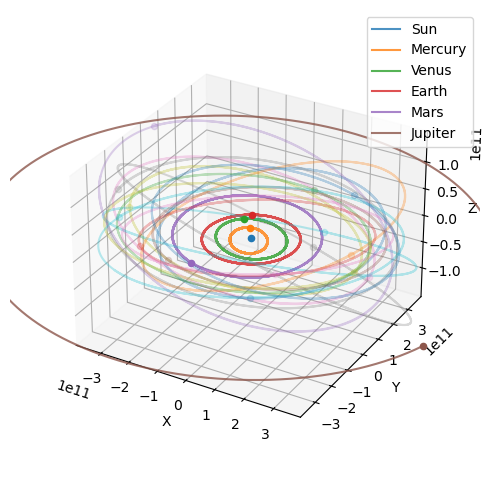

In [77]:
# Plotting the results
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')

# Plot the first 6 bodies (Sun -> Jupiter) with full opacity and the rest with lower opacity
for i in range(0, 6):
    ax.plot(plt_pos[:, i, 0], plt_pos[:, i, 1], plt_pos[:, i, 2], alpha=0.8, label=bodies[i].name)
    ax.scatter(plt_pos[-1, i, 0], plt_pos[-1, i, 1], plt_pos[-1, i, 2], marker="o")

# Plot 15/500 asteroids with lower opacity
for i in range(9, 24):
    ax.plot(plt_pos[:, i, 0], plt_pos[:, i, 1], plt_pos[:, i, 2], alpha=0.3)
    ax.scatter(plt_pos[-1, i, 0], plt_pos[-1, i, 1], plt_pos[-1, i, 2], marker="o", alpha=0.2)

ax.set_box_aspect(None, zoom=0.85)
limits = [2.5, 2.5, 100]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax.set(
    zlim3d=(-limits[2] * AU * 1e-2, limits[2] * AU * 1e-2),
    zlabel="Z",
)
ax.legend()
fig.tight_layout()

## Scaling up the number of bodies N

Let's plot the relative compute time of each method against the number of bodies in the simulation.

In [ ]:
asteroid_ids = list(range(200000, 201991, 1))  # Example asteroid IDs
bodies = []

for x, y in planet_masses.items():
    id = planet_ids[list(planet_masses.keys()).index(x)]
    body_data = Horizons(id=id, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding {x} with id {id}")
    bodies.append(Body(x, 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      y))

for x in asteroid_ids: 
    body_data = Horizons(id=x, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding Asteroid {x}")
    bodies.append(Body(f"Asteroid {x}", 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      1e20))  # Assuming a mass of 1e20 kg for asteroids

with open('data/bodies_ast_large.pkl', 'wb') as f:
    pickle.dump(bodies, f)

Adding Sun with id 10
Adding Venus with id 299
Adding Earth with id 399
Adding Mars with id 499
Adding Jupiter with id 599
Adding Saturn with id 699
Adding Uranus with id 799
Adding Neptune with id 899
Adding Asteroid 200000
Adding Asteroid 200001
Adding Asteroid 200002
Adding Asteroid 200003
Adding Asteroid 200004
Adding Asteroid 200005
Adding Asteroid 200006
Adding Asteroid 200007
Adding Asteroid 200008
Adding Asteroid 200009
Adding Asteroid 200010
Adding Asteroid 200011
Adding Asteroid 200012
Adding Asteroid 200013
Adding Asteroid 200014
Adding Asteroid 200015
Adding Asteroid 200016
Adding Asteroid 200017
Adding Asteroid 200018
Adding Asteroid 200019
Adding Asteroid 200020
Adding Asteroid 200021
Adding Asteroid 200022
Adding Asteroid 200023
Adding Asteroid 200024
Adding Asteroid 200025
Adding Asteroid 200026
Adding Asteroid 200027
Adding Asteroid 200028
Adding Asteroid 200029
Adding Asteroid 200030
Adding Asteroid 200031
Adding Asteroid 200032
Adding Asteroid 200033
Adding Asteroid 

In [83]:
with open('data/bodies_ast_large.pkl', 'rb') as f:
	bodies = pickle.load(f)

In [ ]:
bodies_count_steps = [10, 20, 40, 80, 160]

cpu_times = []
gpu_times = []

for N in bodies_count_steps:
	bodies_temp = bodies[:N]
	t1 = perf_counter_ns()

	plt_pos, N = run_sim_cpu(
		bodies=bodies[:N],
		t = 10 * 365 * day_s,
		dt = 0.1 * day_s
	)

	t2 = perf_counter_ns()

	cpu_times.append((t2-t1)/1e9)

for N in bodies_count_steps:
	bodies_temp = bodies[:N]
	t1 = perf_counter_ns()

	plt_pos, N = run_sim_gpu(
		bodies=bodies[:N],
		t = 10 * 365 * day_s,
		dt = 0.1 * day_s
	)

	t2 = perf_counter_ns()

	gpu_times.append((t2-t1)/1e9)

with open('data/cpu_times.pkl', 'wb') as f:
	pickle.dump(cpu_times, f)

with open('data/gpu_times.pkl', 'wb') as f:
	pickle.dump(gpu_times, f)

In [ ]:
with open('data/cpu_times.pkl', 'rb') as f:
	cpu_times = pickle.load(f)

with open('data/gpu_times.pkl', 'rb') as f:
	gpu_times = pickle.load(f)


plt.plot(bodies_count_steps, cpu_times)
plt.plot(bodies_count_steps, gpu_times)
plt.xlabel('Body Count')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Body Count')

Now let's try to simulate a more complex orbit, we'll use JWST as the test case. We choose a starting time of 2022-01-25 as this is date after it's performed all maneuvers to enter the halo orbit around L2

In [66]:
epoch = Time('2022-01-25')

bodies = []
for x, y in planet_masses.items():
    id = planet_ids[list(planet_masses.keys()).index(x)]
    body_data = Horizons(id=id, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding {x} with id {id}")
    bodies.append(Body(x, 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      y))

jwst_data = Horizons(id='-170', location='@0', epochs=epoch.jd, id_type='majorbody')
jwst_data_v = jwst_data.vectors()
bodies.append(Body("JWST",
				  [jwst_data_v['x'][0]*AU, jwst_data_v['y'][0]*AU, jwst_data_v['z'][0]*AU],
				  [jwst_data_v['vx'][0]*(AU/day_s), jwst_data_v['vy'][0]*(AU/day_s), jwst_data_v['vz'][0]*(AU/day_s)],
				  6500)) # Assuming a mass of 6500 kg for JWST

with open('data/bodies_jwst.pkl', 'wb') as f:
    pickle.dump(bodies, f)

Adding Sun with id 10
Adding Venus with id 299
Adding Earth with id 399
Adding Mars with id 499
Adding Jupiter with id 599
Adding Saturn with id 699
Adding Uranus with id 799
Adding Neptune with id 899


In [67]:
with open('data/bodies_jwst.pkl', 'rb') as f:
	bodies = pickle.load(f)

In [68]:
%%time

t = 1 * 365 * day_s
dt = 0.01 * day_s

# Run the simulation on CPU as its faster for low body count
plt_pos, N = run_sim_cpu(
    bodies=bodies,
    t=t,
    dt=dt
)

CPU times: total: 3.95 s
Wall time: 3.96 s


-4


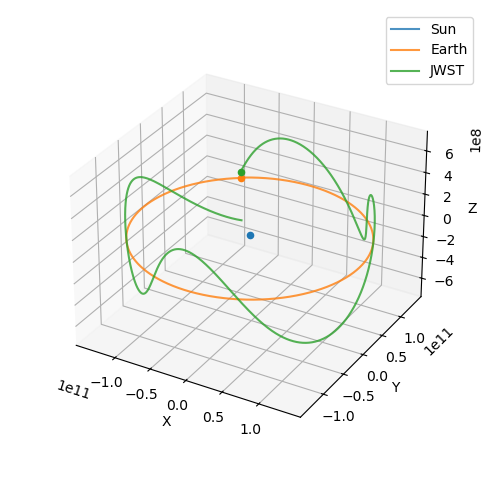

In [69]:
# Plotting the results
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')
print(plt_pos.shape[1]-13)

# Plot the first 5 bodies (Sun -> Jupiter) with full opacity and the rest with lower opacity
ax.plot(plt_pos[:, 0, 0], plt_pos[:, 0, 1], plt_pos[:, 0, 2], alpha=0.8, label=bodies[0].name)
ax.scatter(plt_pos[-1, 0, 0], plt_pos[-1, 0, 1], plt_pos[-1, 0, 2], marker="o")

# Plot the first 5 bodies (Sun -> Jupiter) with full opacity and the rest with lower opacity
ax.plot(plt_pos[:, 2, 0], plt_pos[:, 2, 1], plt_pos[:, 2, 2], alpha=0.8, label=bodies[2].name)
ax.scatter(plt_pos[-1, 2, 0], plt_pos[-1, 2, 1], plt_pos[-1, 2, 2], marker="o")

# Plot JWST with full opacity
ax.plot(plt_pos[:, -1, 0], plt_pos[:, -1, 1], plt_pos[:, -1, 2], alpha=0.8, label='JWST')
ax.scatter(plt_pos[-1, -1, 0], plt_pos[-1, -1, 1], plt_pos[-1, -1, 2], marker="o")

ax.set_box_aspect(None, zoom=0.85)
limits = [1, 1, 0.005]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax.set(
    zlim3d=(-limits[2] * AU, limits[2] * AU),
    zlabel="Z",
)
ax.legend()
fig.tight_layout()

And now compare to the true trajectory as quoted by the NASA Horizons API

In [ ]:
epoch = Time('2022-01-25')

from concurrent.futures import ThreadPoolExecutor 
times = epoch + np.arange(0, N) * 1  # Create an array of times for the simulation

jwst_true = [Horizons(id=-170, location='@0', epochs=time.jd) for time in times]
jwst_true_v = [0 for _ in jwst_true]
for index, request in enumerate(jwst_true):
	# Fetch the vectors for each time step
	try:
		jwst_true_v[index] = request.vectors()
		print(f"Vectors at time {times[index]}: Fetched Successfully")
	except Exception as e:
		print(f"Vectors at time {times[index]}: Exception {e}")


""" def get_vectors(index, request):
	try:
		jwst_true_v[index] = request.vectors()
		print(f"Thread {index}: Finished Successfully")
	except Exception as e:
		print(f"Thread {index}: Exception {e}") """

""" with ThreadPoolExecutor(max_workers=20) as executor:
		for index, request in enumerate(jwst_true):
			executor.submit(get_vectors, index, request) """

with open("data/jwst_true_v", "wb") as fp:
	pickle.dump(jwst_true_v, fp)

Thread 0: Finished Successfully
Thread 1: Finished Successfully
Thread 2: Finished Successfully
Thread 3: Finished Successfully
Thread 4: Finished Successfully
Thread 5: Finished Successfully
Thread 6: Finished Successfully
Thread 7: Finished Successfully
Thread 8: Finished Successfully
Thread 9: Finished Successfully
Thread 10: Finished Successfully
Thread 11: Finished Successfully
Thread 12: Finished Successfully
Thread 13: Finished Successfully
Thread 14: Finished Successfully
Thread 15: Finished Successfully
Thread 16: Finished Successfully
Thread 17: Finished Successfully
Thread 18: Finished Successfully
Thread 19: Finished Successfully
Thread 20: Finished Successfully
Thread 21: Finished Successfully
Thread 22: Finished Successfully
Thread 23: Finished Successfully
Thread 24: Finished Successfully
Thread 25: Finished Successfully
Thread 26: Finished Successfully
Thread 27: Finished Successfully
Thread 28: Finished Successfully
Thread 29: Finished Successfully
Thread 30: Finished 

<Time object: scale='utc' format='iso' value=['2022-01-25 00:00:00.000' '2022-01-26 00:00:00.000'
 '2022-01-27 00:00:00.000' '2022-01-28 00:00:00.000'
 '2022-01-29 00:00:00.000' '2022-01-30 00:00:00.000'
 '2022-01-31 00:00:00.000' '2022-02-01 00:00:00.000'
 '2022-02-02 00:00:00.000' '2022-02-03 00:00:00.000'
 '2022-02-04 00:00:00.000' '2022-02-05 00:00:00.000'
 '2022-02-06 00:00:00.000' '2022-02-07 00:00:00.000'
 '2022-02-08 00:00:00.000' '2022-02-09 00:00:00.000'
 '2022-02-10 00:00:00.000' '2022-02-11 00:00:00.000'
 '2022-02-12 00:00:00.000' '2022-02-13 00:00:00.000'
 '2022-02-14 00:00:00.000' '2022-02-15 00:00:00.000'
 '2022-02-16 00:00:00.000' '2022-02-17 00:00:00.000'
 '2022-02-18 00:00:00.000' '2022-02-19 00:00:00.000'
 '2022-02-20 00:00:00.000' '2022-02-21 00:00:00.000'
 '2022-02-22 00:00:00.000' '2022-02-23 00:00:00.000'
 '2022-02-24 00:00:00.000' '2022-02-25 00:00:00.000'
 '2022-02-26 00:00:00.000' '2022-02-27 00:00:00.000'
 '2022-02-28 00:00:00.000' '2022-03-01 00:00:00.000'
 

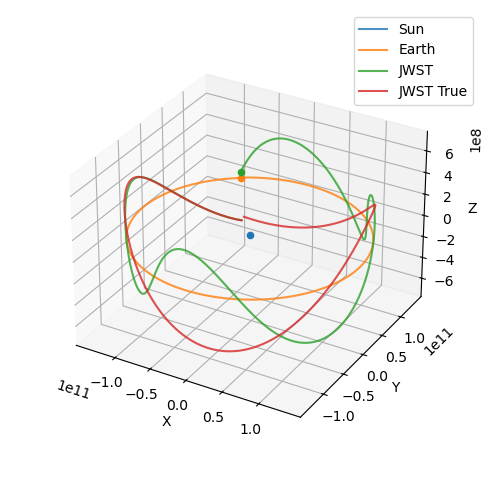

In [70]:
with open("data/jwst_true_v", "rb") as fp:
	jwst_true_v = pickle.load(fp)

# Plotting the results
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')

# Plot the first 5 bodies (Sun -> Jupiter) with full opacity and the rest with lower opacity
ax.plot(plt_pos[:, 0, 0], plt_pos[:, 0, 1], plt_pos[:, 0, 2], alpha=0.8, label=bodies[0].name)
ax.scatter(plt_pos[-1, 0, 0], plt_pos[-1, 0, 1], plt_pos[-1, 0, 2], marker="o")

# Plot the first 5 bodies (Sun -> Jupiter) with full opacity and the rest with lower opacity
ax.plot(plt_pos[:, 2, 0], plt_pos[:, 2, 1], plt_pos[:, 2, 2], alpha=0.8, label=bodies[2].name)
ax.scatter(plt_pos[-1, 2, 0], plt_pos[-1, 2, 1], plt_pos[-1, 2, 2], marker="o")

# Plot JWST with full opacity
ax.plot(plt_pos[:, -1, 0], plt_pos[:, -1, 1], plt_pos[:, -1, 2], alpha=0.8, label='JWST')
ax.scatter(plt_pos[-1, -1, 0], plt_pos[-1, -1, 1], plt_pos[-1, -1, 2], marker="o")

jwst_data_plot_xyz = np.zeros((len(jwst_true_v), 3))

for i in range(len(jwst_true_v)):
	jwst_data_plot_xyz[i, 0] = jwst_true_v[i]["x"].data.data[0]
	jwst_data_plot_xyz[i, 1] = jwst_true_v[i]["y"].data.data[0]
	jwst_data_plot_xyz[i, 2] = jwst_true_v[i]["z"].data.data[0]

ax.plot(jwst_data_plot_xyz[:, 0] * AU, jwst_data_plot_xyz[:, 1] * AU, jwst_data_plot_xyz[:, 2] * AU, alpha=0.8, label='JWST True')

ax.set_box_aspect(None, zoom=0.85)
limits = [1, 1, 0.005]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax.set(
    zlim3d=(-limits[2] * AU, limits[2] * AU),
    zlabel="Z",
)
ax.legend()
fig.tight_layout()


Not great - orbit deviates after a single oscillation, let's try including the moon in our simulation. Previously unimportant due to it's mass and distance from other bodies however, here it may be more important.

In [43]:
epoch = Time('2022-01-25')

bodies = []
for x, y in planet_masses.items():
    id = planet_ids[list(planet_masses.keys()).index(x)]
    body_data = Horizons(id=id, location='@0', epochs=epoch.jd, id_type='majorbody')
    body_data_v = body_data.vectors()
    print(f"Adding {x} with id {id}")
    bodies.append(Body(x, 
                      [body_data_v['x'][0]*AU, body_data_v['y'][0]*AU, body_data_v['z'][0]*AU],
                      [body_data_v['vx'][0]*(AU/day_s), body_data_v['vy'][0]*(AU/day_s), body_data_v['vz'][0]*(AU/day_s)],
                      y))

jwst_data = Horizons(id='-170', location='@0', epochs=epoch.jd, id_type='majorbody')
jwst_data_v = jwst_data.vectors()
bodies.append(Body("JWST",
				  [jwst_data_v['x'][0]*AU, jwst_data_v['y'][0]*AU, jwst_data_v['z'][0]*AU],
				  [jwst_data_v['vx'][0]*(AU/day_s), jwst_data_v['vy'][0]*(AU/day_s), jwst_data_v['vz'][0]*(AU/day_s)],
				  6500)) # Assuming a mass of 6500 kg for JWST
moon_data = Horizons(id='301', location='@0', epochs=epoch.jd, id_type='majorbody')
moon_data_v = moon_data.vectors()
bodies.append(Body("Moon",
				  [moon_data_v['x'][0]*AU, moon_data_v['y'][0]*AU, moon_data_v['z'][0]*AU],
				  [moon_data_v['vx'][0]*(AU/day_s), moon_data_v['vy'][0]*(AU/day_s), moon_data_v['vz'][0]*(AU/day_s)],
				  7.34767309e22)) # Assuming a mass of 7.34767309e22 kg for the Moon


with open('data/bodies_jwst_moon.pkl', 'wb') as f:
    pickle.dump(bodies, f)

Adding Sun with id 10
Adding Venus with id 299
Adding Earth with id 399
Adding Mars with id 499
Adding Jupiter with id 599
Adding Saturn with id 699
Adding Uranus with id 799
Adding Neptune with id 899


In [71]:
with open('data/bodies_jwst_moon.pkl', 'rb') as f:
	bodies = pickle.load(f)

In [72]:
%%time

t = 1 * 365 * day_s
dt = 0.001 * day_s

# Run the simulation on CPU as its faster for low body count
plt_pos, N = run_sim_cpu(
    bodies=bodies,
    t=t,
    dt=dt
)

CPU times: total: 42 s
Wall time: 42 s


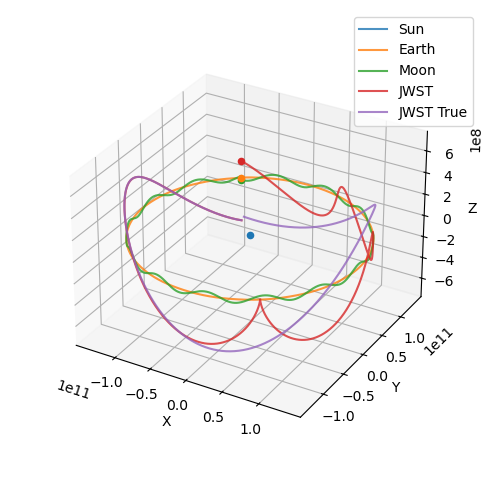

In [74]:
with open("data/jwst_true_v", "rb") as fp:
	jwst_true_v = pickle.load(fp)

# Plotting the results
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')

# Plot the Sun
ax.plot(plt_pos[:, 0, 0], plt_pos[:, 0, 1], plt_pos[:, 0, 2], alpha=0.8, label=bodies[0].name)
ax.scatter(plt_pos[-1, 0, 0], plt_pos[-1, 0, 1], plt_pos[-1, 0, 2], marker="o")

# Plot the Earth
ax.plot(plt_pos[:, 2, 0], plt_pos[:, 2, 1], plt_pos[:, 2, 2], alpha=0.8, label=bodies[2].name)
ax.scatter(plt_pos[-1, 2, 0], plt_pos[-1, 2, 1], plt_pos[-1, 2, 2], marker="o")

# Plot the Moon
ax.plot(plt_pos[:, -1, 0], plt_pos[:, -1, 1], plt_pos[:, -1, 2], alpha=0.8, label='Moon')
ax.scatter(plt_pos[-1, -1, 0], plt_pos[-1, -1, 1], plt_pos[-1, -1, 2], marker="o")

# Plot JWST with full opacity
ax.plot(plt_pos[:, -2, 0], plt_pos[:, -2, 1], plt_pos[:, -2, 2], alpha=0.8, label='JWST')
ax.scatter(plt_pos[-1, -2, 0], plt_pos[-1, -2, 1], plt_pos[-1, -2, 2], marker="o")

jwst_data_plot_xyz = np.zeros((len(jwst_true_v), 3))

for i in range(len(jwst_true_v)):
	jwst_data_plot_xyz[i, 0] = jwst_true_v[i]["x"].data.data[0]
	jwst_data_plot_xyz[i, 1] = jwst_true_v[i]["y"].data.data[0]
	jwst_data_plot_xyz[i, 2] = jwst_true_v[i]["z"].data.data[0]

ax.plot(jwst_data_plot_xyz[:, 0] * AU, jwst_data_plot_xyz[:, 1] * AU, jwst_data_plot_xyz[:, 2] * AU, alpha=0.8, label='JWST True')

ax.set_box_aspect(None, zoom=0.85)
limits = [1, 1, 0.005]
ax.set(xlim3d=(-limits[0] * AU, limits[0] * AU), xlabel="X")
ax.set(ylim3d=(-limits[1] * AU, limits[1] * AU), ylabel="Y")
ax.set(
    zlim3d=(-limits[2] * AU, limits[2] * AU),
    zlabel="Z",
)
ax.legend()
fig.tight_layout()

## Conclusion

This project demonstrates how the Runge-Kutta integration method can be used to simulate planetary motion with good accuracy. By leveraging **GPU acceleration via CuPy**, we achieved substantial performance gains over traditional CPU-based computation.

Such techniques are essential in high-performance scientific computing, where large-scale simulations demand efficient numerical solvers and hardware utilization.
